In [22]:
import os

import imageio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

In [23]:
A = np.array([[0, 0, 1, 0], [0, 0, 0, 1], [0, .7, 0, 0], [0, 2, 0, 0]])
B = np.array([0, 0, 1, .5])


def calculate_next_state(state, time_delta, u):
    if callable(u):
        u = u(state)
    return state + time_delta * (A @ state + B * u)


def simulate_states(initial_state, time_end, time_delta=0.01, u=.4):
    time = 0
    current_state = initial_state
    states = {0: initial_state}
    while time <= time_end and abs(current_state[1]) < 1:
        time += time_delta
        current_state = calculate_next_state(current_state, time_delta, u)
        states[time] = current_state
    return states


def visualize_states(states, title="Zustandsverlauf"):
    fig, ax = plt.subplots()
    ax.plot(states.keys(), states.values(), label=["$p$", "$\\theta$", "$\\dot{p}$", "$\\dot{\\theta}$"])
    ax.set_title(title)
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Zustand")
    ax.legend(loc='upper left')


def calculate_positions(states, arm_length=4):
    positions = {}
    for time, state in states.items():
        theta = state[1]
        p = state[0]

        x = p + np.sin(theta) * arm_length
        y = np.cos(theta) * arm_length
        positions[time] = np.array([x, y])
    return positions


def visualize_positions(positions, title="Positionsverlauf"):
    fig, ax = plt.subplots()
    ax.plot(positions.keys(), positions.values(), label=["x", "y"])
    ax.set_title(title)
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Länge")
    ax.legend(loc='upper left')

def calculate_joint_positions(states, arm_length=4):
    positions = {}
    i = 0
    for time, state in states.items():
        theta = state[1]
        p = state[0]
        base = np.array([p, 0])
        arm = base + np.array([np.sin(theta), np.cos(theta)]) * arm_length
        positions[i] = np.vstack([base, arm])
        i += 1
    return positions

def animate_joint_positions(positions, interval=0.01, title="Positionsanimation", dpi=150):
    array = np.array(list(positions.values()))
    y_max = np.max(array[:, :, 1])
    y_min = np.min(array[:, :, 1])

    x_max = np.max(array[:, :, 0])
    x_min = np.min(array[:, :, 0])

    def plot_frame(frame):
        position = positions[frame]

        fig, ax = plt.subplots()

        ax.plot(position[:, 0], position[:, 1], "b")
        ax.plot(position[:, 0], position[:, 1], "ro")
        ax.text(0.02, 0.95, f'Zeit $t={frame * interval}$', transform=ax.transAxes)
        ax.set_ylim(y_min - 1, y_max + 1)
        ax.set_xlim(x_min - 1, x_max + 1)
        ax.set_title(title)
        ax.set_xlabel("x [m]")
        ax.set_ylabel("y [m]")

        filename = f'build/{title}_{frame}.png'
        fig.savefig(filename, dpi=dpi)
        plt.close(fig)
        return filename

    if not os.path.exists("build/"):
        os.mkdir("build/")

    filenames = [plot_frame(frame) for frame in range(len(positions))]

    gif_filename = f"{title}.gif"

    with imageio.get_writer(gif_filename, mode="I", duration=interval) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)

    for filename in set(filenames):
        os.remove(filename)

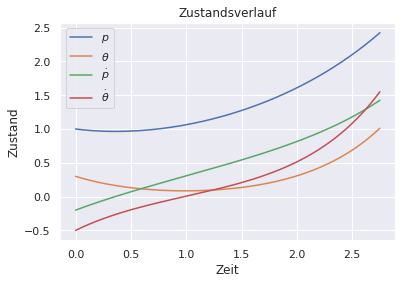

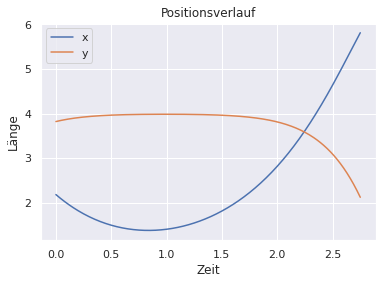

In [24]:
simulation_1 = simulate_states(np.array([1, .3, -.2, -.5]), 100, u=.4)
visualize_states(simulation_1)

visualize_positions(calculate_positions(simulation_1))

animate_joint_positions(calculate_joint_positions(simulation_1))